In [2]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyspark
from pyspark.sql.session import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import col, format_number
from pyspark.sql.functions import col, sum
from pyspark.sql import functions as F
from pyspark.sql.functions import max as sparkMax
from pyspark import SparkContext
from pyspark.context import SparkContext
from pyspark import SparkConf
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from matplotlib import style

In [3]:
spark = SparkSession.builder.appName("excel-reader").config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.7").getOrCreate()

In [4]:
# Read Dataset BPS format xlsx
df = spark.read.format("com.crealytics.spark.excel").option("useHeader", "true").option("inferSchema", "true").option("sheetName", "Sheet1").option("header", "true").load(r"C:\Users\thund\Downloads\Jumlah Perjalanan Wisatawan Nasional, 2023.xlsx")

In [49]:
df.dropna()

DataFrame[Pintu Masuk Wisnas: string, Januari: double, Februari: double, Maret: double, April: double, Mei: double, Juni: double, Juli: double, Agustus: double, September: double, Oktober: double, November: string, Desember: string, Tahunan: string]

In [47]:
df = df.withColumnRenamed("_c0", "Pintu Masuk Wisnas").withColumnRenamed("Unnamed: 1", "Januari").withColumnRenamed("Unnamed: 2", "Februari").withColumnRenamed("Unnamed: 3", "Maret").withColumnRenamed("Unnamed: 4", "April").withColumnRenamed("Unnamed: 5", "Mei").withColumnRenamed("Unnamed: 6", "Juni").withColumnRenamed("Unnamed: 7", "Juli").withColumnRenamed("Unnamed: 8", "Agustus").withColumnRenamed("Unnamed: 9", "September").withColumnRenamed("Unnamed: 10", "Oktober").withColumnRenamed("Unnamed: 11", "November").withColumnRenamed("Unnamed: 12", "Desember").withColumnRenamed("Unnamed: 13", "Tahunan")

In [48]:
df.show(39)

+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+-------+
|  Pintu Masuk Wisnas| Januari|Februari|   Maret|   April|     Mei|    Juni|    Juli| Agustus|September| Oktober|November|Desember|Tahunan|
+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+-------+
|I. PINTU MASUK UTAMA|313610.0|286765.0|326255.0|256292.0|318882.0|236416.0|378320.0|281806.0| 270662.0|345016.0|       -|       -|      -|
|      A. Pintu Udara| 56142.0| 55464.0| 58401.0| 37760.0| 40126.0| 27648.0| 68836.0| 45875.0|  54878.0| 64831.0|       -|       -|      -|
|          Ngurah Rai| 60680.0| 51199.0| 55858.0| 46957.0| 49207.0| 49102.0| 64520.0| 48064.0|  46855.0| 53202.0|       -|       -|      -|
|      Soekarno Hatta|313610.0|286765.0|326255.0|256292.0|318882.0|236416.0|378320.0|281806.0| 270662.0|345016.0|       -|       -|      -|
|              Juand

In [8]:
df.count()

30

In [9]:
len(df.columns)

14

In [10]:
df.printSchema()

root
 |-- Pintu Masuk Wisnas: string (nullable = true)
 |-- Januari: double (nullable = true)
 |-- Februari: double (nullable = true)
 |-- Maret: double (nullable = true)
 |-- April: double (nullable = true)
 |-- Mei: double (nullable = true)
 |-- Juni: double (nullable = true)
 |-- Juli: double (nullable = true)
 |-- Agustus: double (nullable = true)
 |-- September: double (nullable = true)
 |-- Oktober: double (nullable = true)
 |-- November: string (nullable = true)
 |-- Desember: string (nullable = true)
 |-- Tahunan: string (nullable = true)



In [11]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------+--------+-------+
|summary|Pintu Masuk Wisnas|           Januari|          Februari|             Maret|             April|               Mei|              Juni|              Juli|           Agustus|         September|           Oktober|November|Desember|Tahunan|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------+--------+-------+
|  count|                30|                30|                30|                30|                30|                30|                30|                30|                30|                30|                30|      30|      30|     30|
|   mean|           

In [12]:
df.head(5)

[Row(Pintu Masuk Wisnas='I. PINTU MASUK UTAMA', Januari=313610.0, Februari=286765.0, Maret=326255.0, April=256292.0, Mei=318882.0, Juni=236416.0, Juli=378320.0, Agustus=281806.0, September=270662.0, Oktober=345016.0, November='-', Desember='-', Tahunan='-'),
 Row(Pintu Masuk Wisnas='A. Pintu Udara', Januari=56142.0, Februari=55464.0, Maret=58401.0, April=37760.0, Mei=40126.0, Juni=27648.0, Juli=68836.0, Agustus=45875.0, September=54878.0, Oktober=64831.0, November='-', Desember='-', Tahunan='-'),
 Row(Pintu Masuk Wisnas='Ngurah Rai', Januari=60680.0, Februari=51199.0, Maret=55858.0, April=46957.0, Mei=49207.0, Juni=49102.0, Juli=64520.0, Agustus=48064.0, September=46855.0, Oktober=53202.0, November='-', Desember='-', Tahunan='-'),
 Row(Pintu Masuk Wisnas='Soekarno Hatta', Januari=313610.0, Februari=286765.0, Maret=326255.0, April=256292.0, Mei=318882.0, Juni=236416.0, Juli=378320.0, Agustus=281806.0, September=270662.0, Oktober=345016.0, November='-', Desember='-', Tahunan='-'),
 Row(P

In [13]:
# Tidying Tables
cleaned_df = df.na.drop()

In [14]:
selected_columns = ['Pintu Masuk Wisnas', 'Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember', 'Tahunan']

In [15]:
describe_df = cleaned_df.describe(selected_columns)

In [16]:
formatted_describe_df = describe_df.select(describe_df["summary"], *[format_number(col(c).cast("double"), 2).alias(c) for c in selected_columns])

In [17]:
formatted_describe_df.show()

+-------+------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+-------+
|summary|Pintu Masuk Wisnas|   Januari|  Februari|     Maret|     April|       Mei|      Juni|      Juli|   Agustus| September|   Oktober|November|Desember|Tahunan|
+-------+------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+-------+
|  count|             30.00|     30.00|     30.00|     30.00|     30.00|     30.00|     30.00|     30.00|     30.00|     30.00|     30.00|   30.00|   30.00|  30.00|
|   mean|              NULL| 59,641.73| 52,037.77| 57,884.17| 51,222.57| 54,261.03| 48,234.43| 73,093.00| 53,203.17| 51,732.37| 60,287.03|    NULL|    NULL|   NULL|
| stddev|              NULL|138,768.72|122,792.72|137,459.56|117,538.33|129,386.52|107,665.08|170,661.60|123,277.78|119,706.45|144,106.64|    NULL|    NULL|   NULL|
|    min| 

In [18]:
df.select("Pintu Masuk Wisnas", "Januari", "Agustus").show(39)

+--------------------+--------+--------+
|  Pintu Masuk Wisnas| Januari| Agustus|
+--------------------+--------+--------+
|I. PINTU MASUK UTAMA|313610.0|281806.0|
|      A. Pintu Udara| 56142.0| 45875.0|
|          Ngurah Rai| 60680.0| 48064.0|
|      Soekarno Hatta|313610.0|281806.0|
|              Juanda|  4409.0|  5696.0|
|           Kualanamu|   699.0|  1079.0|
| Husein Sastranegara|  1140.0|  1152.0|
|     Adi Sucipto/YIA|  4442.0|  5417.0|
|Bandara Int'l Lombok|  9379.0| 10302.0|
|       Sam Ratulangi|  4193.0|  4236.0|
|Sultan Iskandar Muda| 14178.0| 13294.0|
|             Supadio|  1452.0| 12328.0|
|          Hasanuddin|126004.0| 95152.0|
|Sultan Badaruddin II| 82269.0| 65133.0|
|             Lainnya|   364.0|   207.0|
|       B. Pintu Laut|  4701.0|  3786.0|
|               Batam| 19328.0|  7571.0|
|      Tanjung Pinang| 19322.0| 18455.0|
|Tanjung Balai Kar...| 36754.0| 38411.0|
|       Tanjung Benoa|    54.0|   402.0|
|             Lainnya|  4830.0| 13805.0|
|      C. Pintu 

In [19]:
null_counts = [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]

In [20]:
df.agg(*null_counts).show()

+------------------+-------+--------+-----+-----+---+----+----+-------+---------+-------+--------+--------+-------+
|Pintu Masuk Wisnas|Januari|Februari|Maret|April|Mei|Juni|Juli|Agustus|September|Oktober|November|Desember|Tahunan|
+------------------+-------+--------+-----+-----+---+----+----+-------+---------+-------+--------+--------+-------+
|                 0|      0|       0|    0|    0|  0|   0|   0|      0|        0|      0|       0|       0|      0|
+------------------+-------+--------+-----+-----+---+----+----+-------+---------+-------+--------+--------+-------+



In [21]:
column = df.columns

In [22]:
for column in column:
    print(column)

Pintu Masuk Wisnas
Januari
Februari
Maret
April
Mei
Juni
Juli
Agustus
September
Oktober
November
Desember
Tahunan


In [23]:
# Analytics Big Data
df.groupBy("Februari").count().show()

+--------+-----+
|Februari|count|
+--------+-----+
|  4855.0|    1|
|   928.0|    1|
|286765.0|    2|
|   765.0|    1|
| 51199.0|    1|
|  4794.0|    1|
|  8096.0|    1|
| 55464.0|    1|
|  4270.0|    1|
| 16868.0|    1|
| 15865.0|    1|
| 97681.0|    1|
|  3470.0|    1|
| 26008.0|    1|
| 17894.0|    1|
|   106.0|    1|
| 60147.0|    1|
|  1382.0|    1|
|   192.0|    1|
|577251.0|    1|
+--------+-----+
only showing top 20 rows



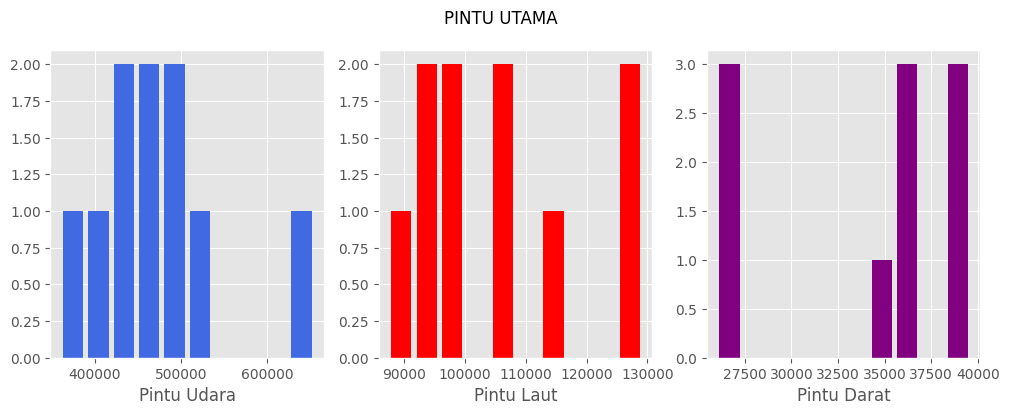

In [24]:
# Create Histogram
style.use('ggplot')

pintu_udara = [490940, 448740, 501990, 394237, 461828, 360098, 654912, 444467, 438038, 534566]
pintu_laut = [126004, 97681, 106943, 129177, 95926, 105123, 114917, 95152, 87406, 94473]
pintu_darat = [36754, 26008, 27215, 36468, 27278, 34711, 39605, 38411, 36216, 38436]

fig = plt.figure(figsize=(12, 4))
fig.suptitle('PINTU UTAMA')
plt.subplot(1, 3, 1)
plt.hist(pintu_udara, rwidth=0.8, color='royalblue', bins=10)
plt.xlabel("Pintu Udara")
plt.subplot(1, 3, 2)
plt.hist(pintu_laut, rwidth=0.8, color='red', bins=10)
plt.xlabel("Pintu Laut")
plt.subplot(1, 3, 3)
plt.hist(pintu_darat, rwidth=0.8, color='purple', bins=10)
plt.xlabel("Pintu Darat")
plt.show()

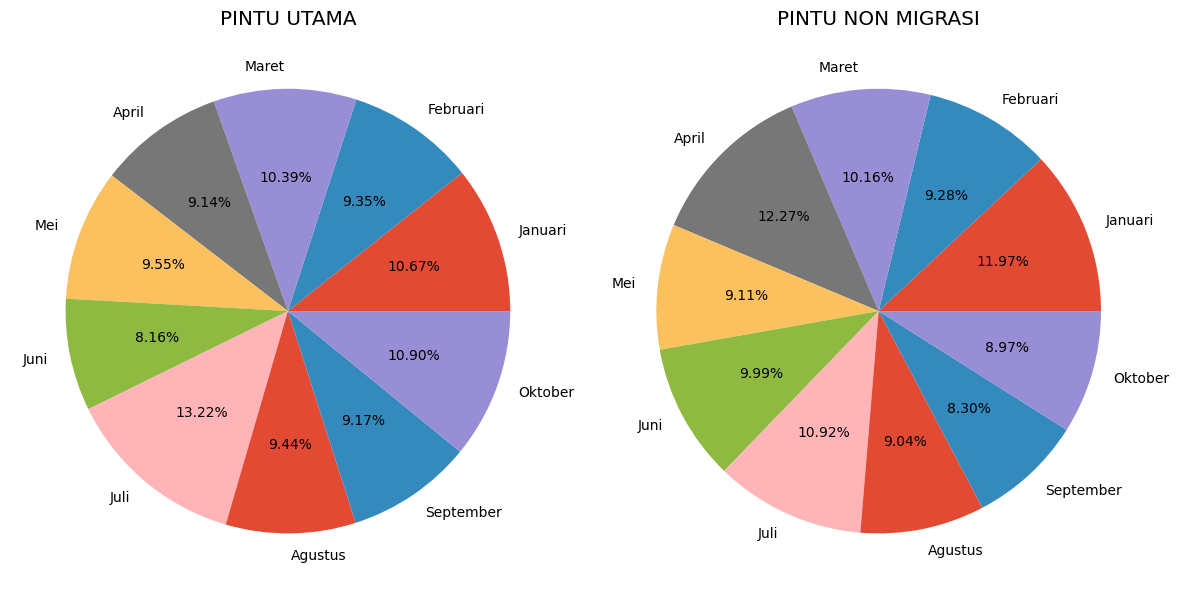

In [25]:
# Pie Chart
style.use('ggplot')
bulan = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober']

pintu_utama = [653698, 572429, 636148, 559882, 585032, 499932, 809434, 578030, 561660, 667475]
pintu_non_migrasi = [126004, 97681, 106943, 129177, 95926, 105123, 114917, 95152, 87406, 94473]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('PINTU UTAMA')
axes[0].pie(pintu_utama, labels=bulan, autopct='%1.2f%%')
axes[1].set_title('PINTU NON MIGRASI')
axes[1].pie(pintu_non_migrasi, labels=bulan, autopct='%1.2f%%')
plt.tight_layout()
plt.show()

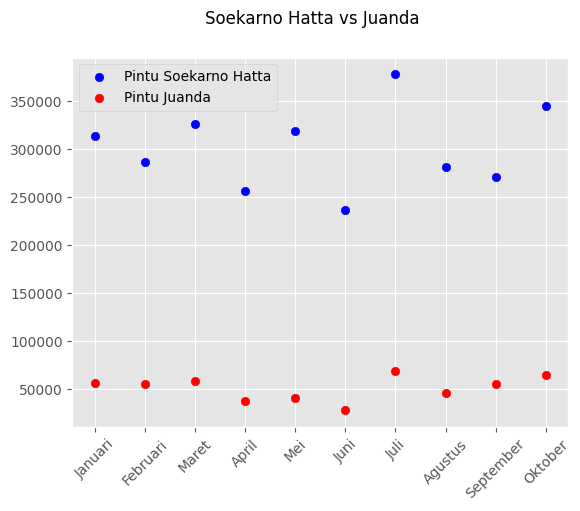

In [26]:
# Scatter Plot
style.use('ggplot')
bulan = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober']

pintu_soehatt = [313610, 286765, 326255, 256292, 318882, 236416, 378320, 281806, 270662, 345016]
pintu_juanda = [56142, 55464, 58401, 37760, 40126, 27648, 68836, 45875, 54878, 64831]

plt.suptitle('Soekarno Hatta vs Juanda')
plt.scatter(bulan, pintu_soehatt, label='Pintu Soekarno Hatta', color='blue')
plt.scatter(bulan, pintu_juanda, label='Pintu Juanda', color='red')
plt.xticks(rotation=45)
plt.legend()
plt.show()

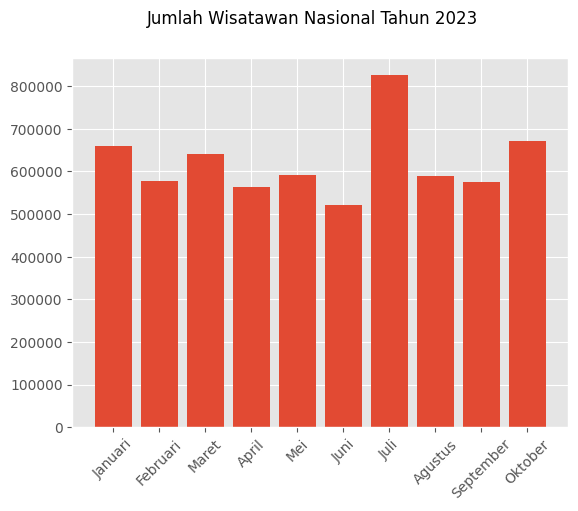

In [27]:
 # Bar Chart
style.use('ggplot')
bulan = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober']

total = [660229, 577251, 641248, 563563, 592855, 521501, 826152, 588248, 574630, 671073]

plt.suptitle('Jumlah Wisatawan Nasional Tahun 2023')
plt.bar(bulan, total)
plt.xticks(rotation=45)
plt.show()

In [28]:
input_cols = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober']

In [29]:
vec_assembler = VectorAssembler(inputCols= input_cols, outputCol= "features")

In [30]:
final_data = vec_assembler.transform(df)

In [41]:
final_data.show(39)

+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+-------+--------------------+
|  Pintu Masuk Wisnas| Januari|Februari|   Maret|   April|     Mei|    Juni|    Juli| Agustus|September| Oktober|November|Desember|Tahunan|            features|
+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+-------+--------------------+
|I. PINTU MASUK UTAMA|313610.0|286765.0|326255.0|256292.0|318882.0|236416.0|378320.0|281806.0| 270662.0|345016.0|       -|       -|      -|[313610.0,286765....|
|      A. Pintu Udara| 56142.0| 55464.0| 58401.0| 37760.0| 40126.0| 27648.0| 68836.0| 45875.0|  54878.0| 64831.0|       -|       -|      -|[56142.0,55464.0,...|
|          Ngurah Rai| 60680.0| 51199.0| 55858.0| 46957.0| 49207.0| 49102.0| 64520.0| 48064.0|  46855.0| 53202.0|       -|       -|      -|[60680.0,51199.0,...|
|      Soekarno Hatta|313610.0|286

In [32]:
kmeans = KMeans(featuresCol="features", k=3)

In [33]:
model = kmeans.fit(final_data)

In [34]:
model

KMeansModel: uid=KMeans_143062be539d, k=3, distanceMeasure=euclidean, numFeatures=10

In [35]:
model.transform(final_data).groupBy("Agustus").count().show(39)

+--------+-----+
| Agustus|count|
+--------+-----+
|  1152.0|    1|
| 10302.0|    1|
|  5696.0|    1|
|281806.0|    2|
| 45875.0|    1|
| 48064.0|    1|
|  4236.0|    1|
|  5417.0|    1|
|  1079.0|    1|
| 38411.0|    1|
| 13294.0|    1|
| 18455.0|    1|
|  3786.0|    1|
|   207.0|    1|
| 65133.0|    1|
|   402.0|    1|
| 12328.0|    1|
|  7571.0|    1|
| 95152.0|    1|
|  3085.0|    2|
| 13805.0|    1|
|  7133.0|    2|
|588248.0|    1|
| 13793.0|    1|
|  2362.0|    1|
|  7061.0|    1|
| 10218.0|    1|
+--------+-----+



In [36]:
predictions = model.transform(final_data)

In [37]:
predictions.show()

+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+-------+--------------------+----------+
|  Pintu Masuk Wisnas| Januari|Februari|   Maret|   April|     Mei|    Juni|    Juli| Agustus|September| Oktober|November|Desember|Tahunan|            features|prediction|
+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+-------+--------------------+----------+
|I. PINTU MASUK UTAMA|313610.0|286765.0|326255.0|256292.0|318882.0|236416.0|378320.0|281806.0| 270662.0|345016.0|       -|       -|      -|[313610.0,286765....|         1|
|      A. Pintu Udara| 56142.0| 55464.0| 58401.0| 37760.0| 40126.0| 27648.0| 68836.0| 45875.0|  54878.0| 64831.0|       -|       -|      -|[56142.0,55464.0,...|         0|
|          Ngurah Rai| 60680.0| 51199.0| 55858.0| 46957.0| 49207.0| 49102.0| 64520.0| 48064.0|  46855.0| 53202.0|       -|       -|      -|[

In [44]:
predictions.groupBy("Pintu Masuk Wisnas", "Maret", "Januari").count().show(39)

+--------------------+--------+--------+-----+
|  Pintu Masuk Wisnas|   Maret| Januari|count|
+--------------------+--------+--------+-----+
|          Ngurah Rai| 55858.0| 60680.0|    1|
|Bandara Int'l Lombok|  8728.0|  9379.0|    1|
|I. PINTU MASUK UTAMA|326255.0|313610.0|    1|
| Husein Sastranegara|  1047.0|  1140.0|    1|
|       Sam Ratulangi|  3638.0|  4193.0|    1|
|     Adi Sucipto/YIA|  4746.0|  4442.0|    1|
|      Soekarno Hatta|326255.0|313610.0|    1|
|              Juanda|  5051.0|  4409.0|    1|
|      A. Pintu Udara| 58401.0| 56142.0|    1|
|           Kualanamu|   593.0|   699.0|    1|
|          Hasanuddin|106943.0|126004.0|    1|
|       Tanjung Benoa|   172.0|    54.0|    1|
|               Batam| 21397.0| 19328.0|    1|
|      Tanjung Pinang| 17322.0| 19322.0|    1|
|Sultan Badaruddin II| 64261.0| 82269.0|    1|
|       B. Pintu Laut|  3700.0|  4701.0|    1|
|             Supadio|  2754.0|  1452.0|    1|
|Sultan Iskandar Muda| 18365.0| 14178.0|    1|
|            